# Import Package

In [8]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageFile,UnidentifiedImageError, ImageEnhance,ImageOps
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew
import random
import torch
import seaborn as sns
import pickle
import mediapipe as mp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# STEP 1:  Problem Understanding 

- Bài toán: Nhận diện ký hiệu cơ thể chuyển sang ngôn ngữ đọc nói từ ảnh và video có sẵn.

- Loại bài toán: Phân loại ký hiệu tay, xử lý chuỗi văn bản, chuyển văn bản sang giọng nói .

- Đầu vào:  Các ảnh và video bàn tay và cơ thể người đang thưc hiện các ký hiệu.

- Output : (target) đưa ra văn bản và giọng nói sau khi đã nhận diện được chuỗi hành dộng.

- Mục tiêu: Giúp người khiếm thính và người khiếm thị có thể giao tiếp tốt với mọi người xung quanh.

# STEP 2: Data Understanding.

Mục đích: Hiểu rõ chất lượng đặc điểm và tiền xử lý dữ liệu ảnh

Bao gồm 
- Inconsistent: Tìm dữ liệu không nhất quán
- Data Overview: Kiểm tra tổng quan dữ liệu( số lượng ảnh và kích thước phổ biến)
- Imbalanced: Kiểm tra sự mất cân bằng giữa các lớp ( A, B, C, ...)
- Data Augmentation : Tăng cường dữ liệu 

In [9]:
# 2.1 Tìm dữ liệu không nhất quán 
dataset_path="../dataset"

# duyệt từng tệp trong từng thư mục con của dataset

for person in os.listdir(dataset_path): 
    person_path = os.path.join(dataset_path, person)
    for img_file in os.listdir(person_path):
        img_path = os.path.join(person_path, img_file)
        try:
            with Image.open(img_path) as img:
                img.verify()  # hàm xác minh ảnh
        except (UnidentifiedImageError, OSError):
            print(f"Ảnh lỗi: {img_path} \n Thực hiện xóa...")
            os.remove(img_path)  

In [10]:
# 2.2 kiểm tra số lượng ảnh và kích thước phổ biến
sizes = []
for person in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person)
    for img_file in os.listdir(person_path):
        img_path = os.path.join(person_path, img_file)
        try:
            with Image.open(img_path) as img:
                sizes.append(img.size)
        except:
            pass  # Bỏ qua ảnh lỗi đã phát hiện ở trên

print("Số lượng ảnh:", len(sizes))
print("Kích thước phổ biến nhất:", max(set(sizes), key=sizes.count))

Số lượng ảnh: 4181
Kích thước phổ biến nhất: (225, 360)


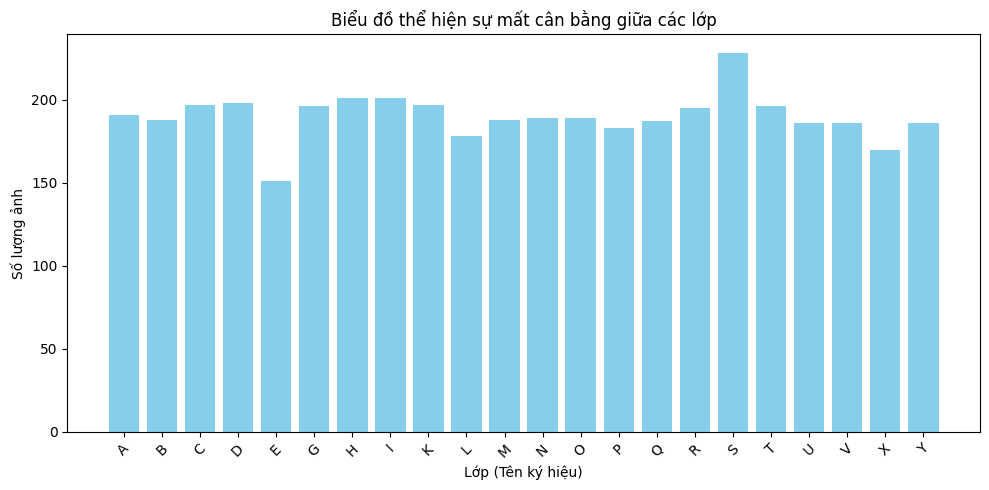

In [11]:
# 2.3 Kiểm tra sự mất cân bằng giữa các lớp

class_counts = defaultdict(int)

# Đếm số lượng ảnh của mỗi lớp
for person in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person)
    if os.path.isdir(person_path):
        for img_file in os.listdir(person_path):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                class_counts[person] += 1

# Vẽ biểu đồ cột
labels = list(class_counts.keys())
values = list(class_counts.values())

plt.figure(figsize=(10, 5))
plt.bar(labels, values, color='skyblue')
plt.xlabel("Lớp (Tên ký hiệu)")
plt.ylabel("Số lượng ảnh")
plt.title("Biểu đồ thể hiện sự mất cân bằng giữa các lớp")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
# 2.4 Tăng cường dữ liệu
# nếu người nào có số lượng ảnh dưới 60 thì tăng cường bằng các pp tcdl

min_images = 230 
def augment_image(img): # Các phương pháp tăng cường dữ liệu
    operations = [
        lambda x: x.rotate(15), # xoay phải 1 góc 15 độ
        lambda x: x.rotate(-15),# xoay trái 1 góc 15 độ
        lambda x: x.rotate(10), # xoay phải 10 độ
        lambda x: x.rotate(-10),# xoay trái 10 độ
        lambda x: ImageOps.mirror(x), # lật ngang
        lambda x: ImageEnhance.Brightness(x).enhance(1.5), # tăng độ sáng
        lambda x: ImageEnhance.Color(x).enhance(1.5), # tăng độ bão hòa
    ]
    op = random.choice(operations)
    return op(img)

for person in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person)
    if not os.path.isdir(person_path):
        continue

    # Đếm số ảnh hiện có
    imgs = [f for f in os.listdir(person_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    count = len(imgs)
    print(f"{person} hiện có {count} ảnh.")
    if count >= min_images:
        continue  # Không cần tăng cường
    # Tạo thêm ảnh để đủ min_images
    needed = min_images - count
    print(f"Tăng cường thêm {needed} ảnh cho lớp {person}.")

    for i in range(needed):
        # Chọn ngẫu nhiên 1 ảnh gốc để biến đổi
        orig_img_name = random.choice(imgs)
        orig_img_path = os.path.join(person_path, orig_img_name)
        with Image.open(orig_img_path) as img:
            aug_img = augment_image(img)
            # Lưu ảnh mới với tên mới
            new_img_name = f"aug_{i}_{orig_img_name}"
            new_img_path = os.path.join(person_path, new_img_name)
            aug_img.save(new_img_path)

print("Tăng cường dữ liệu hoàn tất.")


A hiện có 191 ảnh.
Tăng cường thêm 39 ảnh cho lớp A.


B hiện có 188 ảnh.
Tăng cường thêm 42 ảnh cho lớp B.
C hiện có 197 ảnh.
Tăng cường thêm 33 ảnh cho lớp C.
D hiện có 198 ảnh.
Tăng cường thêm 32 ảnh cho lớp D.
E hiện có 151 ảnh.
Tăng cường thêm 79 ảnh cho lớp E.
G hiện có 196 ảnh.
Tăng cường thêm 34 ảnh cho lớp G.
H hiện có 201 ảnh.
Tăng cường thêm 29 ảnh cho lớp H.
I hiện có 201 ảnh.
Tăng cường thêm 29 ảnh cho lớp I.
K hiện có 197 ảnh.
Tăng cường thêm 33 ảnh cho lớp K.
L hiện có 178 ảnh.
Tăng cường thêm 52 ảnh cho lớp L.
M hiện có 188 ảnh.
Tăng cường thêm 42 ảnh cho lớp M.
N hiện có 189 ảnh.
Tăng cường thêm 41 ảnh cho lớp N.
O hiện có 189 ảnh.
Tăng cường thêm 41 ảnh cho lớp O.
P hiện có 183 ảnh.
Tăng cường thêm 47 ảnh cho lớp P.
Q hiện có 187 ảnh.
Tăng cường thêm 43 ảnh cho lớp Q.
R hiện có 195 ảnh.
Tăng cường thêm 35 ảnh cho lớp R.
S hiện có 228 ảnh.
Tăng cường thêm 2 ảnh cho lớp S.
T hiện có 196 ảnh.
Tăng cường thêm 34 ảnh cho lớp T.
U hiện có 186 ảnh.
Tăng cường thêm 44 ảnh cho lớp U.
V hiện có 186 ảnh.
Tăng cường thêm 44 ảnh cho l

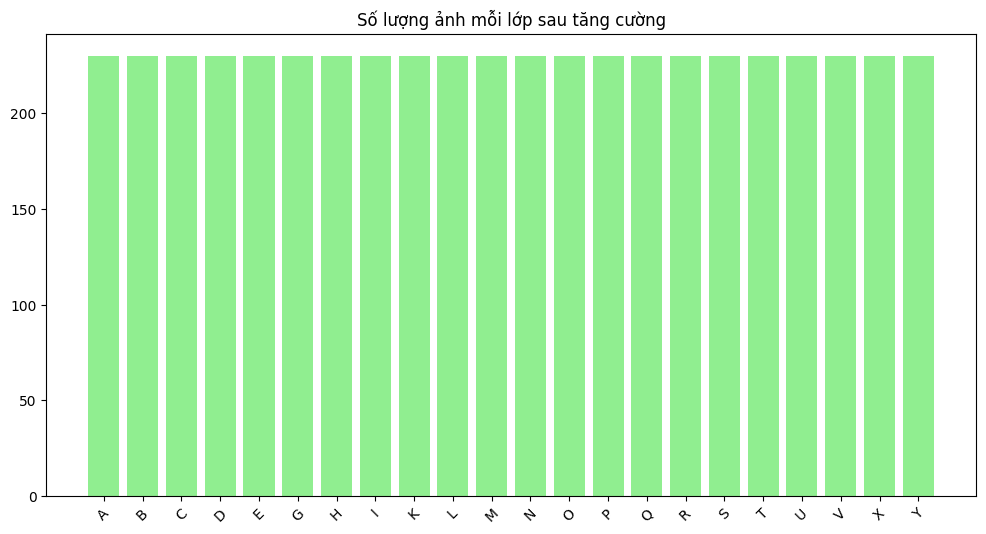

In [13]:
# Kiểm tra lại sự mất cân bằng của các lớp
class_counts = defaultdict(int)
for person in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person)
    if os.path.isdir(person_path):
        class_counts[person] = len([f for f in os.listdir(person_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='lightgreen')
plt.xticks(rotation=45)
plt.title("Số lượng ảnh mỗi lớp sau tăng cường")
plt.show()

# 3. Trích xuất điểm ảnh, đặc trung bàn tay
